In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
class PolynomialRegression:
    """
    Polynomial Regression implementation from scratch.
    """
    def __init__(self, degree=2):
        """
        Initialize the polynomial regression model.
        
        Parameters:
        -----------
        degree : int
            The degree of the polynomial (default is 2)
        """
        self.degree = degree
        self.coefficients = None
        
    def _create_polynomial_features(self, X):
        """
        Transform input features into polynomial features.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Input features of shape (n_samples,) or (n_samples, 1)
            
        Returns:
        --------
        numpy.ndarray
            Polynomial features of shape (n_samples, degree+1)
        """
        if X.ndim == 1:
            X = X.reshape(-1, 1)
            
        n_samples, n_features = X.shape
        
        # For simplicity, we'll only handle one feature for polynomial expansion
        if n_features != 1:
            raise ValueError("This implementation only supports one feature for polynomial expansion")
            
        # Create the polynomial features
        X_poly = np.ones((n_samples, self.degree + 1))
        
        for i in range(1, self.degree + 1):
            X_poly[:, i] = X[:, 0] ** i
            
        return X_poly
        
    def fit(self, X, y):
        """
        Fit the polynomial regression model.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Training data of shape (n_samples,) or (n_samples, 1)
        y : numpy.ndarray
            Target values of shape (n_samples,)
            
        Returns:
        --------
        self : object
            Returns self
        """
        # Create polynomial features
        X_poly = self._create_polynomial_features(X)
        
        # Calculate coefficients using the normal equation: θ = (X^T X)^(-1) X^T y
        # This is a closed-form solution for least squares
        X_T = X_poly.T
        self.coefficients = np.linalg.inv(X_T.dot(X_poly)).dot(X_T).dot(y)
        
        return self
        
    def predict(self, X):
        """
        Predict using the polynomial model.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Samples of shape (n_samples,) or (n_samples, 1)
            
        Returns:
        --------
        numpy.ndarray
            Returns predicted values
        """
        if self.coefficients is None:
            raise ValueError("Model has not been fitted yet. Call 'fit' first.")
            
        # Transform input features
        X_poly = self._create_polynomial_features(X)
        
        # Make predictions
        return X_poly.dot(self.coefficients)
    
    def score(self, X, y):
        """
        Calculate the coefficient of determination R^2.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Test samples of shape (n_samples,) or (n_samples, 1)
        y : numpy.ndarray
            True values for X of shape (n_samples,)
            
        Returns:
        --------
        float
            R^2 score
        """
        y_pred = self.predict(X)
        u = ((y - y_pred) ** 2).sum()
        v = ((y - y.mean()) ** 2).sum()
        
        return 1 - (u / v)


In [3]:
def polynomial_regression_workflow(X, y, degrees=[1, 2, 3, 5], test_size=0.2, random_state=42, 
                                  true_function=None, title="Polynomial Regression Analysis"):
    """
    Complete workflow for polynomial regression analysis.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Feature array of shape (n_samples,) or (n_samples, 1)
    y : numpy.ndarray
        Target array of shape (n_samples,)
    degrees : list
        List of polynomial degrees to try (default: [1, 2, 3, 5])
    test_size : float
        Proportion of the dataset to include in the test split (default: 0.2)
    random_state : int
        Random seed for reproducibility (default: 42)
    true_function : callable, optional
        True function to compare against (if known)
    title : str
        Title for the plots (default: "Polynomial Regression Analysis")
        
    Returns:
    --------
    dict
        Dictionary containing:
        - 'best_model': The best polynomial regression model based on test R²
        - 'best_degree': The degree of the best model
        - 'all_models': Dictionary of all fitted models by degree
        - 'metrics': Dictionary of evaluation metrics for all models
        - 'figures': List of matplotlib figures
    """
    # Ensure X is 1D for easier handling
    if X.ndim > 1 and X.shape[1] == 1:
        X = X.ravel()
        
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Dictionary to store results
    results = {
        'all_models': {},
        'metrics': {},
        'figures': []
    }
    
    # Sort X for plotting smooth curves
    sort_idx = np.argsort(X)
    X_sorted = X[sort_idx]
    
    # Create figure for comparing different polynomial degrees
    fig1, ax1 = plt.subplots(figsize=(12, 8))
    ax1.scatter(X_train, y_train, color='blue', alpha=0.5, label='Training data')
    ax1.scatter(X_test, y_test, color='red', alpha=0.5, label='Test data')
    
    if true_function is not None:
        y_true_sorted = true_function(X_sorted)
        ax1.plot(X_sorted, y_true_sorted, 'k--', linewidth=2, label='True function')
    
    # Fit models of different degrees
    best_r2 = -float('inf')
    best_model = None
    best_degree = None
    
    for degree in degrees:
        # Create and fit model
        model = PolynomialRegression(degree=degree)
        model.fit(X_train, y_train)
        results['all_models'][degree] = model
        
        # Make predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        y_pred_sorted = model.predict(X_sorted)
        
        # Calculate metrics
        train_mse = mean_squared_error(y_train, y_pred_train)
        train_mae = mean_absolute_error(y_train, y_pred_train)
        train_r2 = r2_score(y_train, y_pred_train)
        
        test_mse = mean_squared_error(y_test, y_pred_test)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        test_r2 = r2_score(y_test, y_pred_test)
        
        # Store metrics
        results['metrics'][degree] = {
            'train': {'MSE': train_mse, 'MAE': train_mae, 'R²': train_r2},
            'test': {'MSE': test_mse, 'MAE': test_mae, 'R²': test_r2}
        }
        
        # Plot predictions
        ax1.plot(X_sorted, y_pred_sorted, linewidth=2, 
                label=f'Degree {degree} (Test R² = {test_r2:.3f})')
        
        # Check if this is the best model
        if test_r2 > best_r2:
            best_r2 = test_r2
            best_model = model
            best_degree = degree
    
    # Finalize plot
    ax1.set_title(f'{title}: Model Comparison')
    ax1.set_xlabel('X')
    ax1.set_ylabel('y')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    results['figures'].append(fig1)
    
    # Create figure for metrics comparison
    fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Extract metrics for plotting
    degrees_list = sorted(degrees)
    train_r2_values = [results['metrics'][d]['train']['R²'] for d in degrees_list]
    test_r2_values = [results['metrics'][d]['test']['R²'] for d in degrees_list]
    
    train_mse_values = [results['metrics'][d]['train']['MSE'] for d in degrees_list]
    test_mse_values = [results['metrics'][d]['test']['MSE'] for d in degrees_list]
    
    # Plot R² comparison
    ax2.plot(degrees_list, train_r2_values, 'o-', color='blue', label='Training R²')
    ax2.plot(degrees_list, test_r2_values, 'o-', color='red', label='Test R²')
    ax2.set_xlabel('Polynomial Degree')
    ax2.set_ylabel('R² Score')
    ax2.set_title('R² Score vs. Polynomial Degree')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot MSE comparison
    ax3.plot(degrees_list, train_mse_values, 'o-', color='blue', label='Training MSE')
    ax3.plot(degrees_list, test_mse_values, 'o-', color='red', label='Test MSE')
    ax3.set_xlabel('Polynomial Degree')
    ax3.set_ylabel('Mean Squared Error')
    ax3.set_title('MSE vs. Polynomial Degree')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    results['figures'].append(fig2)
    
    # Best model analysis
    if best_model is not None:
        fig3, ax4 = plt.subplots(figsize=(10, 6))
        
        # Residual plot for best model
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
        
        train_residuals = y_train - y_pred_train
        test_residuals = y_test - y_pred_test
        
        ax4.scatter(y_pred_train, train_residuals, color='blue', alpha=0.5, label='Training')
        ax4.scatter(y_pred_test, test_residuals, color='red', alpha=0.5, label='Test')
        ax4.axhline(y=0, color='black', linestyle='--')
        ax4.set_xlabel('Predicted Values')
        ax4.set_ylabel('Residuals')
        ax4.set_title(f'Residual Plot for Best Model (Degree {best_degree})')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        results['figures'].append(fig3)
    
    # Add best model to results
    results['best_model'] = best_model
    results['best_degree'] = best_degree
    
    # Print summary of results
    print("\n" + "="*50)
    print(f"Polynomial Regression Analysis Summary")
    print("="*50)
    print(f"Best polynomial degree: {best_degree}")
    print(f"Best model coefficients: {best_model.coefficients}")
    print("\nMetrics for all models:")
    
    print("\nTraining Metrics:")
    print(f"{'Degree':<8} {'MSE':<12} {'MAE':<12} {'R²':<12}")
    print("-"*44)
    for degree in degrees_list:
        metrics = results['metrics'][degree]['train']
        print(f"{degree:<8} {metrics['MSE']:<12.4f} {metrics['MAE']:<12.4f} {metrics['R²']:<12.4f}")
    
    print("\nTest Metrics:")
    print(f"{'Degree':<8} {'MSE':<12} {'MAE':<12} {'R²':<12}")
    print("-"*44)
    for degree in degrees_list:
        metrics = results['metrics'][degree]['test']
        print(f"{degree:<8} {metrics['MSE']:<12.4f} {metrics['MAE']:<12.4f} {metrics['R²']:<12.4f}")
    
    return results



Polynomial Regression Analysis Summary
Best polynomial degree: 3
Best model coefficients: [-0.00887688  2.90617996  3.05287905 -0.05496927]

Metrics for all models:

Training Metrics:
Degree   MSE          MAE          R²          
--------------------------------------------
1        573.2469     20.6405      0.0929      
2        21.5064      3.7301       0.9660      
3        20.4006      3.6870       0.9677      
5        19.9296      3.6210       0.9685      
10       18.7326      3.5276       0.9704      

Test Metrics:
Degree   MSE          MAE          R²          
--------------------------------------------
1        486.9607     16.7621      -0.1598     
2        15.4908      3.0032       0.9631      
3        15.0562      2.9155       0.9641      
5        16.2282      3.0780       0.9613      
10       20.4320      3.5099       0.9513      


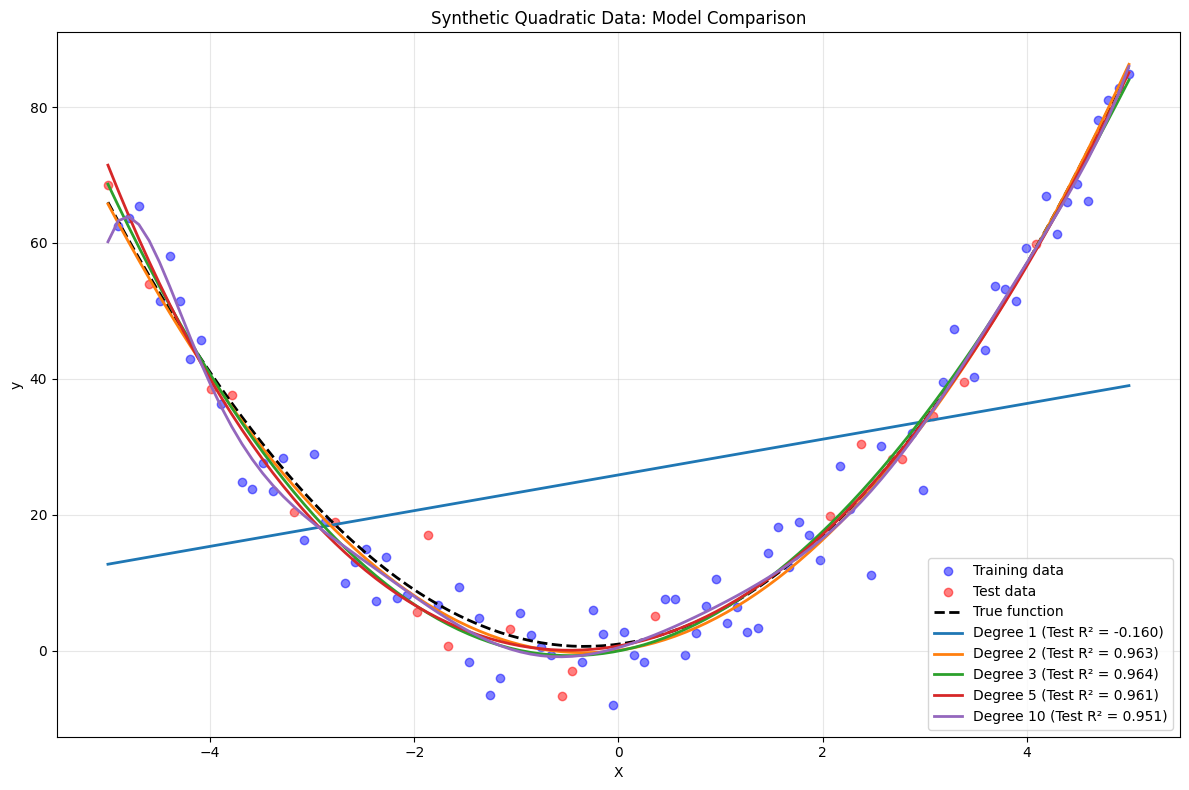

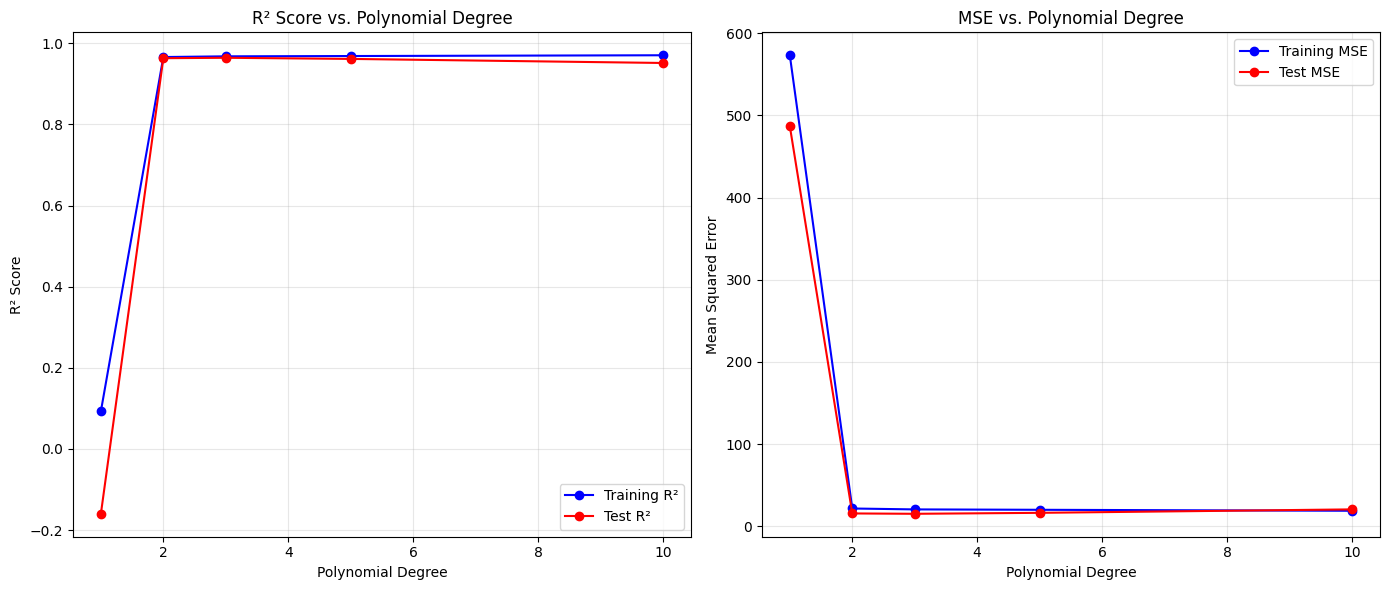

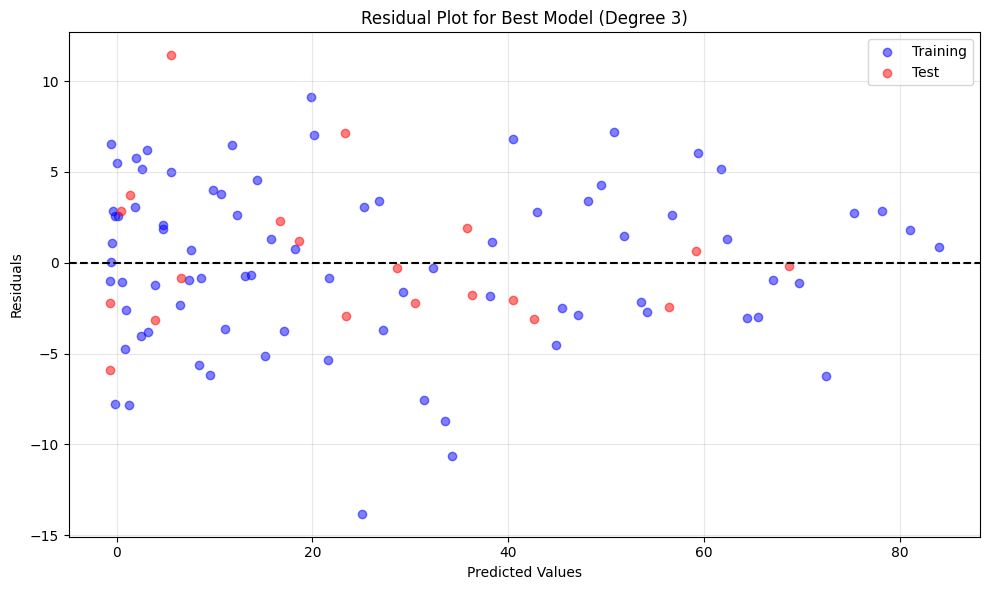

In [4]:
# Example usage
if __name__ == "__main__":
    # Generate synthetic data
    np.random.seed(42)
    X = np.linspace(-5, 5, 100)
    
    # True function: 1 + 2x + 3x^2
    true_fn = lambda x: 1 + 2*x + 3*x**2
    y_true = true_fn(X)
    
    # Add noise to create realistic data
    y = y_true + np.random.normal(0, 5, X.shape)
    
    # Run the complete polynomial regression workflow
    results = polynomial_regression_workflow(
        X, y, 
        degrees=[1, 2, 3, 5, 10], 
        true_function=true_fn, 
        title="Synthetic Quadratic Data"
    )
    
    # Show all figures
    plt.show()


In [6]:
print("Polynomial regression analysis completed.")

Polynomial regression analysis completed.


In [ ]:
def generate_polynomial_regression_documentation(output_filename: str = "polynomial_regression_docs.pdf") -> None:
    """
    Generates professional PDF documentation for the Polynomial Regression implementation.
    
    Features:
    - Mathematical theory explanation
    - Class and method documentation
    - Usage examples
    - Visual diagrams
    - Implementation details
    
    Args:
        output_filename: Path for the output PDF file
    """
    # Document setup
    doc = SimpleDocTemplate(output_filename, pagesize=letter,
                          rightMargin=72, leftMargin=72,
                          topMargin=72, bottomMargin=72)
    
    styles = getSampleStyleSheet()
    story = []
    
    # Custom styles
    title_style = ParagraphStyle(
        'TitleStyle',
        parent=styles['Heading1'],
        fontSize=18,
        leading=22,
        alignment=TA_CENTER,
        spaceAfter=20,
        textColor=colors.darkblue
    )
    
    heading1_style = ParagraphStyle(
        'Heading1Style',
        parent=styles['Heading1'],
        fontSize=14,
        leading=18,
        spaceAfter=12,
        textColor=colors.darkblue
    )
    
    heading2_style = ParagraphStyle(
        'Heading2Style',
        parent=styles['Heading2'],
        fontSize=12,
        leading=16,
        spaceAfter=8,
        textColor=colors.navy
    )
    
    code_style = ParagraphStyle(
        'CodeStyle',
        parent=styles['Code'],
        fontName='Courier',
        fontSize=8,
        leading=10,
        backColor=colors.lightgrey,
        borderPadding=5,
        leftIndent=10
    )
    
    # =====================
    # Title Page
    # =====================
    story.append(Paragraph("Polynomial Regression Implementation", title_style))
    story.append(Spacer(1, 20))
    
    # Add logo/image if available
    try:
        logo = Image("logo.png", width=2*inch, height=2*inch)
        logo.hAlign = 'CENTER'
        story.append(logo)
        story.append(Spacer(1, 20))
    except:
        pass
    
    story.append(Paragraph(f"Documentation Generated: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", 
                         ParagraphStyle('DateStyle', parent=styles['Normal'], alignment=TA_CENTER)))
    story.append(PageBreak())
    
    # =====================
    # Table of Contents
    # =====================
    story.append(Paragraph("Table of Contents", heading1_style))
    story.append(Spacer(1, 12))
    
    toc = [
        ("1. Introduction", "2"),
        ("2. Mathematical Theory", "3"),
        ("3. Implementation Overview", "4"),
        ("4. PolynomialRegression Class", "5"),
        ("5. Workflow Function", "7"),
        ("6. Usage Examples", "9"),
        ("7. Visualizations", "10"),
        ("8. Conclusion", "12")
    ]
    
    for item, page in toc:
        story.append(Paragraph(f"<a href='page{page}'>{item}</a>", 
                             ParagraphStyle('TOCStyle', parent=styles['Normal'], 
                                          leftIndent=20, firstLineIndent=-20,
                                          spaceAfter=6)))
    
    story.append(PageBreak())
    
    # =====================
    # 1. Introduction
    # =====================
    story.append(Paragraph("<a name='page2'></a>1. Introduction", heading1_style))
    intro_text = """
    This document provides comprehensive documentation for the Polynomial Regression implementation from scratch. 
    The implementation includes:
    
    • Complete polynomial regression algorithm without relying on machine learning libraries
    • Feature transformation and model training using normal equations
    • Comprehensive evaluation metrics (MSE, MAE, R²)
    • Visualization capabilities for model analysis
    • Automated documentation generation
    
    <b>Key Features:</b>
    - Support for arbitrary polynomial degrees
    - Detailed model evaluation metrics
    - Comparison of multiple polynomial degrees
    - Residual analysis
    - Professional PDF documentation generation
    
    The implementation follows software engineering best practices including type hints, 
    proper error handling, and modular design.
    """
    story.append(Paragraph(intro_text, styles['Normal']))
    story.append(PageBreak())
    
    # =====================
    # 2. Mathematical Theory
    # =====================
    story.append(Paragraph("<a name='page3'></a>2. Mathematical Theory", heading1_style))
    
    math_text = """
    <b>Polynomial Regression</b> extends linear regression by modeling the relationship between 
    the independent variable (x) and dependent variable (y) as an nth degree polynomial.
    
    The general form of the polynomial regression model is:
    """
    story.append(Paragraph(math_text, styles['Normal']))
    
    # Add equation as an image (better rendering than ReportLab's native math support)
    try:
        # Create equation image
        plt.figure(figsize=(8, 1))
        plt.text(0.5, 0.5, r"$y = \beta_0 + \beta_1x + \beta_2x^2 + \cdots + \beta_nx^n + \varepsilon$", 
                fontsize=14, ha='center', va='center')
        plt.axis('off')
        buf = BytesIO()
        plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        plt.close()
        
        equation_img = Image(buf, width=6*inch, height=0.75*inch)
        equation_img.hAlign = 'CENTER'
        story.append(equation_img)
        story.append(Spacer(1, 12))
    except:
        story.append(Paragraph(r"y = β₀ + β₁x + β₂x² + ... + βₙxⁿ + ε", 
                             ParagraphStyle('EquationStyle', parent=styles['Code'], 
                                          alignment=TA_CENTER)))
    
    theory_text = """
    <b>Where:</b>
    • y: Dependent variable (target)
    • x: Independent variable (feature)
    • β₀, β₁, ..., βₙ: Model coefficients
    • ε: Error term
    
    <b>Model Training:</b>
    The coefficients are calculated using the normal equation:
    """
    story.append(Paragraph(theory_text, styles['Normal']))
    
    # Add normal equation image
    try:
        plt.figure(figsize=(8, 1))
        plt.text(0.5, 0.5, r"$\beta = (X^T X)^{-1} X^T y$", 
                fontsize=14, ha='center', va='center')
        plt.axis('off')
        buf = BytesIO()
        plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        plt.close()
        
        eq_img = Image(buf, width=4*inch, height=0.75*inch)
        eq_img.hAlign = 'CENTER'
        story.append(eq_img)
    except:
        story.append(Paragraph(r"β = (XᵀX)⁻¹Xᵀy", 
                             ParagraphStyle('EquationStyle', parent=styles['Code'], 
                                          alignment=TA_CENTER)))
    
    story.append(PageBreak())
    
    # =====================
    # 3. Implementation Overview
    # =====================
    story.append(Paragraph("<a name='page4'></a>3. Implementation Overview", heading1_style))
    
    overview_text = """
    The implementation consists of two main components:
    
    <b>1. PolynomialRegression Class</b>
    • Core polynomial regression functionality
    • Feature transformation
    • Model training via normal equations
    • Prediction and evaluation
    
    <b>2. polynomial_regression_workflow Function</b>
    • Complete analysis workflow
    • Handles data splitting
    • Trains multiple models with different degrees
    • Generates comprehensive visualizations
    • Produces evaluation metrics
    
    The implementation uses only NumPy for core mathematical operations and matplotlib for visualization.
    """
    story.append(Paragraph(overview_text, styles['Normal']))
    
    # Add architecture diagram if available
    story.append(Spacer(1, 12))
    story.append(Paragraph("<b>Implementation Architecture:</b>", styles['Normal']))
    
    try:
        arch_img = Image("architecture.png", width=5*inch, height=3*inch)
        arch_img.hAlign = 'CENTER'
        story.append(arch_img)
    except:
        story.append(Paragraph("[Architecture diagram placeholder]", styles['Italic']))
    
    story.append(PageBreak())
    
    # =====================
    # 4. PolynomialRegression Class
    # =====================
    story.append(Paragraph("<a name='page5'></a>4. PolynomialRegression Class", heading1_style))
    
    class_text = """
    The <font face='Courier'>PolynomialRegression</font> class implements the core polynomial regression algorithm.
    """
    story.append(Paragraph(class_text, styles['Normal']))
    
    # Class signature
    story.append(Paragraph("<b>Class Definition:</b>", styles['Normal']))
    class_code = """
class PolynomialRegression:
    \"\"\"
    Polynomial Regression implementation from scratch.
    
    Attributes:
        degree (int): Degree of the polynomial
        coefficients (np.ndarray): Model coefficients after fitting
    \"\"\"
    
    def __init__(self, degree: int = 2) -> None:
        \"\"\"Initialize with polynomial degree\"\"\"
        self.degree = degree
        self.coefficients = None
    """
    story.append(Preformatted(class_code, code_style))
    story.append(Spacer(1, 12))
    
    # Methods documentation
    story.append(Paragraph("<b>Key Methods:</b>", heading2_style))
    
    methods = [
        {
            "name": "fit(X, y)",
            "desc": "Trains the model using normal equations",
            "params": [
                ("X", "Input features (1D or 2D array)"),
                ("y", "Target values")
            ],
            "returns": "self (for method chaining)"
        },
        {
            "name": "predict(X)",
            "desc": "Makes predictions using fitted model",
            "params": [
                ("X", "Input features to predict on")
            ],
            "returns": "Array of predicted values"
        },
        {
            "name": "score(X, y)",
            "desc": "Calculates R² score",
            "params": [
                ("X", "Input features"),
                ("y", "True target values")
            ],
            "returns": "R² score (float)"
        }
    ]
    
    for method in methods:
        story.append(Paragraph(f"<b><font face='Courier'>{method['name']}</font></b>", styles['Normal']))
        story.append(Paragraph(method['desc'], styles['Normal']))
        
        # Parameters table
        param_data = [["Parameter", "Description"]] + method['params']
        param_table = Table(param_data, colWidths=[1.5*inch, 4.5*inch])
        param_table.setStyle(TableStyle([
            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
            ('FONTSIZE', (0, 0), (-1, 0), 10,
            ('BACKGROUND', (0, 0), (-1, 0), colors.lightgrey),
            ('GRID', (0, 0), (-1, -1), 0.5, colors.grey),
            ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
            ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
            ('LEFTPADDING', (0, 0), (-1, -1), 3),
            ('RIGHTPADDING', (0, 0), (-1, -1), 3)
        ]))
        story.append(param_table)
        
        story.append(Paragraph(f"<b>Returns:</b> {method['returns']}", styles['Normal']))
        story.append(Spacer(1, 8))
    
    story.append(PageBreak())
    
    # =====================
    # 5. Workflow Function
    # =====================
    story.append(Paragraph("<a name='page7'></a>5. Workflow Function", heading1_style))
    
    workflow_text = """
    The <font face='Courier'>polynomial_regression_workflow</font> function provides a complete analysis pipeline:
    """
    story.append(Paragraph(workflow_text, styles['Normal']))
    
    # Function signature
    story.append(Paragraph("<b>Function Definition:</b>", styles['Normal']))
    workflow_code = """
def polynomial_regression_workflow(
    X: np.ndarray,
    y: np.ndarray,
    degrees: List[int] = [1, 2, 3, 5],
    test_size: float = 0.2,
    random_state: int = 42,
    true_function: Optional[Callable] = None,
    title: str = "Polynomial Regression Analysis"
) -> Dict:
    \"\"\"
    Complete polynomial regression analysis workflow.
    
    Returns dictionary containing:
    - best_model: Best performing model
    - best_degree: Degree of best model
    - all_models: All trained models
    - metrics: Evaluation metrics
    - figures: Generated matplotlib figures
    \"\"\"
    """
    story.append(Preformatted(workflow_code, code_style))
    
    # Workflow steps
    story.append(Paragraph("<b>Workflow Steps:</b>", heading2_style))
    
    steps = [
        ("1. Data Preparation", "Splits data into training/test sets"),
        ("2. Model Training", "Trains models for each polynomial degree"),
        ("3. Evaluation", "Calculates MSE, MAE, R² for each model"),
        ("4. Visualization", "Generates comparison plots and residual analysis"),
        ("5. Model Selection", "Selects best model based on test performance")
    ]
    
    step_data = [["Step", "Description"]] + steps
    step_table = Table(step_data, colWidths=[1.5*inch, 4.5*inch])
    step_table.setStyle(TableStyle([
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 10,
        ('BACKGROUND', (0, 0), (-1, 0), colors.lightgrey),
        ('GRID', (0, 0), (-1, -1), 0.5, colors.grey),
        ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
        ('ALIGN', (0, 0), (-1, -1), 'LEFT')
    ]))
    story.append(step_table)
    
    story.append(PageBreak())
    
    # =====================
    # 6. Usage Examples
    # =====================
    story.append(Paragraph("<a name='page9'></a>6. Usage Examples", heading1_style))
    
    story.append(Paragraph("<b>Basic Usage:</b>", heading2_style))
    basic_code = """
# Create and fit model
model = PolynomialRegression(degree=3)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate model
r2 = model.score(X_test, y_test)
    """
    story.append(Preformatted(basic_code, code_style))
    
    story.append(Paragraph("<b>Complete Workflow Example:</b>", heading2_style))
    workflow_example = """
# Generate synthetic data
np.random.seed(42)
X = np.linspace(-3, 3, 100)
y = 2 + 3*X - 1.5*X**2 + 0.5*X**3 + np.random.normal(0, 2, 100)

# Run complete analysis
results = polynomial_regression_workflow(
    X, y,
    degrees=[1, 2, 3, 4, 5],
    true_function=lambda x: 2 + 3*x - 1.5*x**2 + 0.5*x**3
)

# Access results
print(f"Best degree: {results['best_degree']}")
print(f"Best R² score: {results['metrics'][results['best_degree']]['test']['R²']:.3f}")
    """
    story.append(Preformatted(workflow_example, code_style))
    
    story.append(PageBreak())
    
    # =====================
    # 7. Visualizations
    # =====================
    story.append(Paragraph("<a name='page10'></a>7. Visualizations", heading1_style))
    
    viz_text = """
    The workflow generates several visualizations to analyze model performance:
    """
    story.append(Paragraph(viz_text, styles['Normal']))
    
    viz_types = [
        ("Model Comparison", "Shows fits of different polynomial degrees"),
        ("Metrics Comparison", "Compares R² and MSE across degrees"),
        ("Residual Analysis", "Plots residuals for best model")
    ]
    
    viz_data = [["Visualization", "Description"]] + viz_types
    viz_table = Table(viz_data, colWidths=[2*inch, 4*inch])
    viz_table.setStyle(TableStyle([
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 10,
        ('BACKGROUND', (0, 0), (-1, 0), colors.lightgrey),
        ('GRID', (0, 0), (-1, -1), 0.5, colors.grey),
        ('VALIGN', (0, 0), (-1, -1), 'MIDDLE')
    ]))
    story.append(viz_table)
    
    # Add example visualization if available
    story.append(Spacer(1, 12))
    story.append(Paragraph("<b>Example Visualization:</b>", styles['Normal']))
    
    try:
        # Generate and add example plot
        np.random.seed(42)
        X = np.linspace(-3, 3, 100)
        y = 2 + 3*X - 1.5*X**2 + 0.5*X**3 + np.random.normal(0, 2, 100)
        
        plt.figure(figsize=(8, 5))
        plt.scatter(X, y, color='blue', alpha=0.5, label='Data')
        plt.plot(X, 2 + 3*X - 1.5*X**2 + 0.5*X**3, 
                'k--', linewidth=2, label='True function')
        plt.title("Example Polynomial Regression Data")
        plt.xlabel("X")
        plt.ylabel("y")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        buf = BytesIO()
        plt.savefig(buf, format='png', dpi=150, bbox_inches='tight')
        plt.close()
        
        example_img = Image(buf, width=5*inch, height=3*inch)
        example_img.hAlign = 'CENTER'
        story.append(example_img)
    except:
        story.append(Paragraph("[Example visualization placeholder]", styles['Italic']))
    
    story.append(PageBreak())
    
    # =====================
    # 8. Conclusion
    # =====================
    story.append(Paragraph("<a name='page12'></a>8. Conclusion", heading1_style))
    
    conclusion_text = """
    This implementation provides a complete polynomial regression solution with:
    
    • <b>Mathematical Rigor</b>: Proper implementation of normal equations
    • <b>Comprehensive Analysis</b>: Multiple evaluation metrics and visualizations
    • <b>Professional Documentation</b>: Self-explanatory PDF documentation
    
    The modular design makes it easy to extend for specific use cases while maintaining 
    the core mathematical correctness.
    """
    story.append(Paragraph(conclusion_text, styles['Normal']))
    
    # Generate the PDF
    doc.build(story)